In [31]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove100d/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Introduction

In this notebook we will explore basic sentiment analysis using deep learning. This dataset consists of only 3,000 tweets which is pretty small for a deep learning project. Each tweet is labeled as being real disaster or not.

In [32]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [33]:
train_df.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [34]:
data = [x for x in train_df['text']]
labels = [x for x in train_df['target']]

In [35]:
data, labels = shuffle(data, labels)

# Basic EDA

We will start with some very basic EDA and preprocessing. I am using GloVe embeddings, which I use to create an embedding matrix. I then convert each tweet into the tokenized verison, where each word is replaced with an integer representing its position into the embedding matrix. I then pad each tweet with 0's so they are the same size.

In [36]:
len(data)

7613

In [37]:
max_len = 0
tweet_lens = []
for ex in data:
    tweet_lens.append(len(ex))
    if len(ex) > max_len:
        max_len = len(ex)
max_len

157

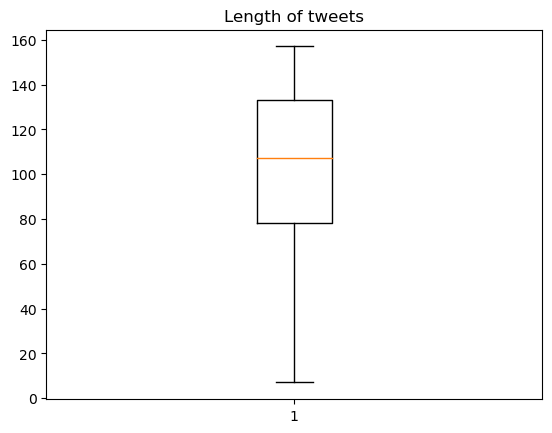

In [38]:
plt.boxplot(tweet_lens)
plt.title('Length of tweets')
plt.show()

In [39]:
positive = 0
negative = 0
for label in labels:
    if label == 1:
        positive += 1
    else:
        negative += 1

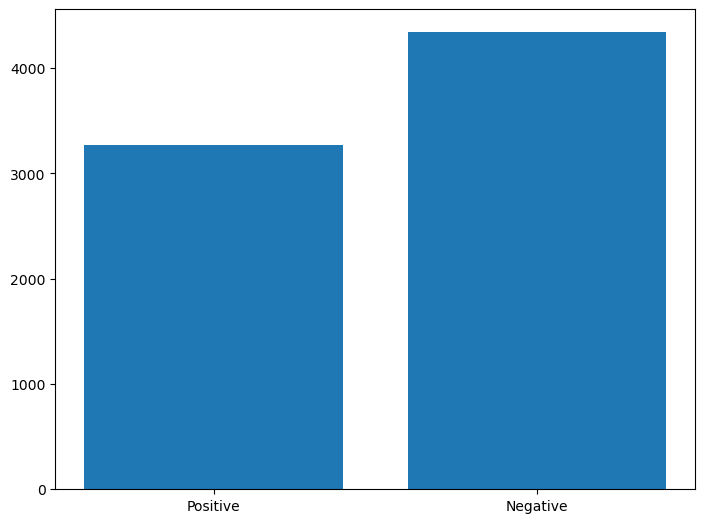

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l = ['Positive', 'Negative']
v = [positive, negative]
ax.bar(l,v)
plt.show()

# Data cleaning and more EDA

Here I have some basic data cleaning by removing removing URL's, Twitter username handles, hashtags and numbers. I also generate word clouds to get a sense of the most common words in the dataset. This will also give me a better idea if I need to improve my data cleaning.

In [41]:
def preprocess(tweet):
    #Regex patterns
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    hashPattern       = '#[^\s]+'
    
    tweet = tweet.lower()
    #Remove all URL's
    tweet = re.sub(urlPattern, '', tweet)
    #Remove all @users
    tweet = re.sub(userPattern, '', tweet)
    #Remove all #hashtags
    tweet = re.sub(hashPattern, '', tweet)
    #Remove all non alphabet characters
    tweet = re.sub(alphaPattern, ' ', tweet)
    
    return tweet

In [42]:
for i in range(len(data)):
    data[i] = preprocess(data[i])

In [43]:
pos = []
neg = []
for i in range(len(data)):
    if labels[i] == 1:
        pos.append(data[i])
    else:
        neg.append(data[i])

In [44]:
def gen_wordcloud(data):
    plt.figure(figsize = (20,20))
    wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
                   collocations=False).generate(" ".join(data))
    plt.imshow(wc)

## Word cloud for disaster tweets

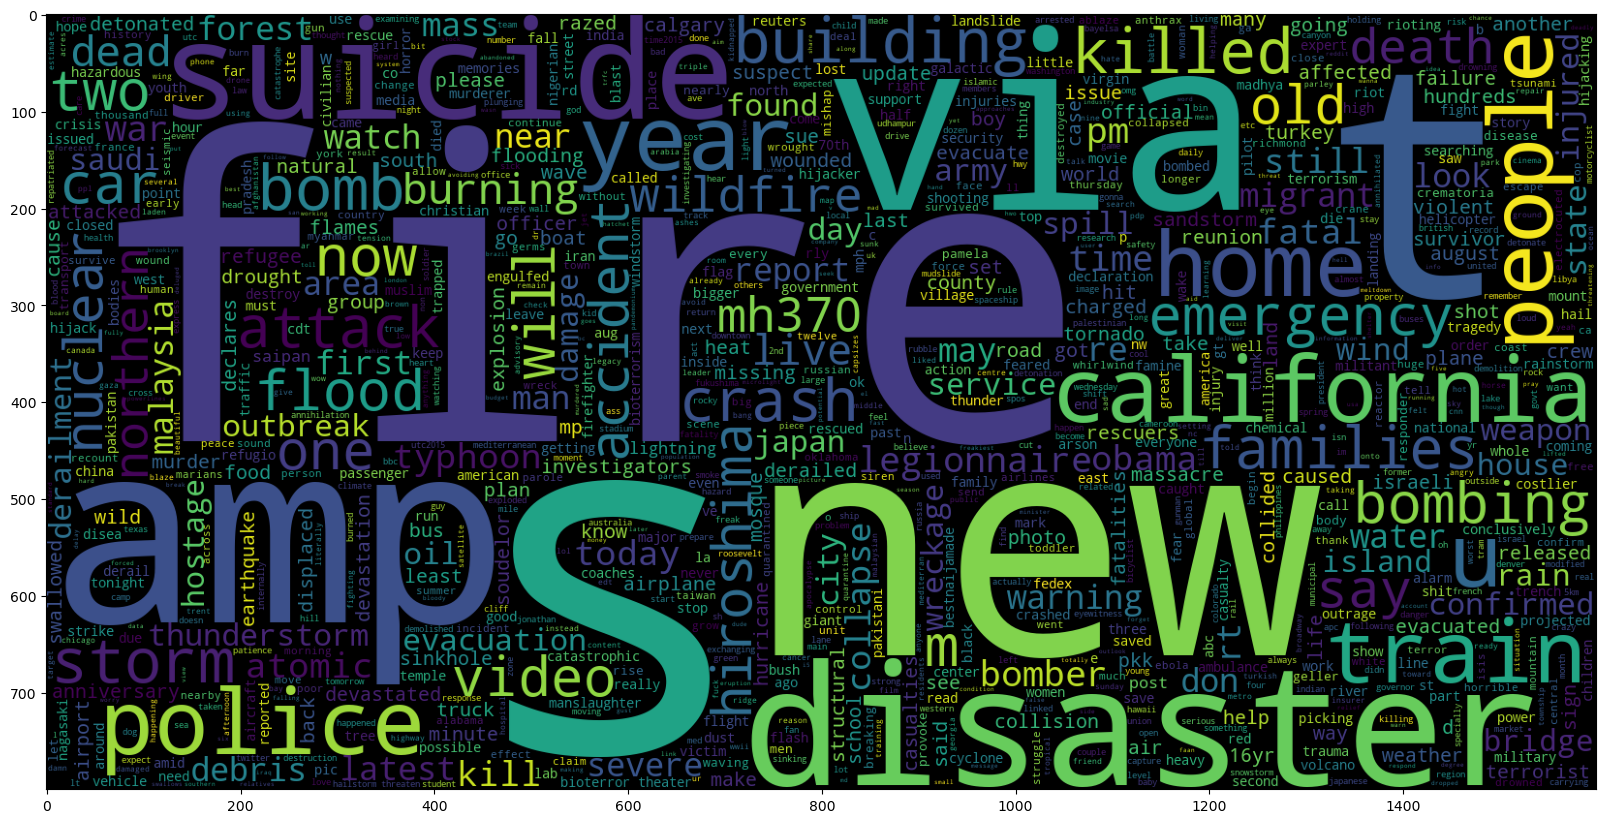

In [45]:
gen_wordcloud(pos)

## Word cloud for non-disaster tweets

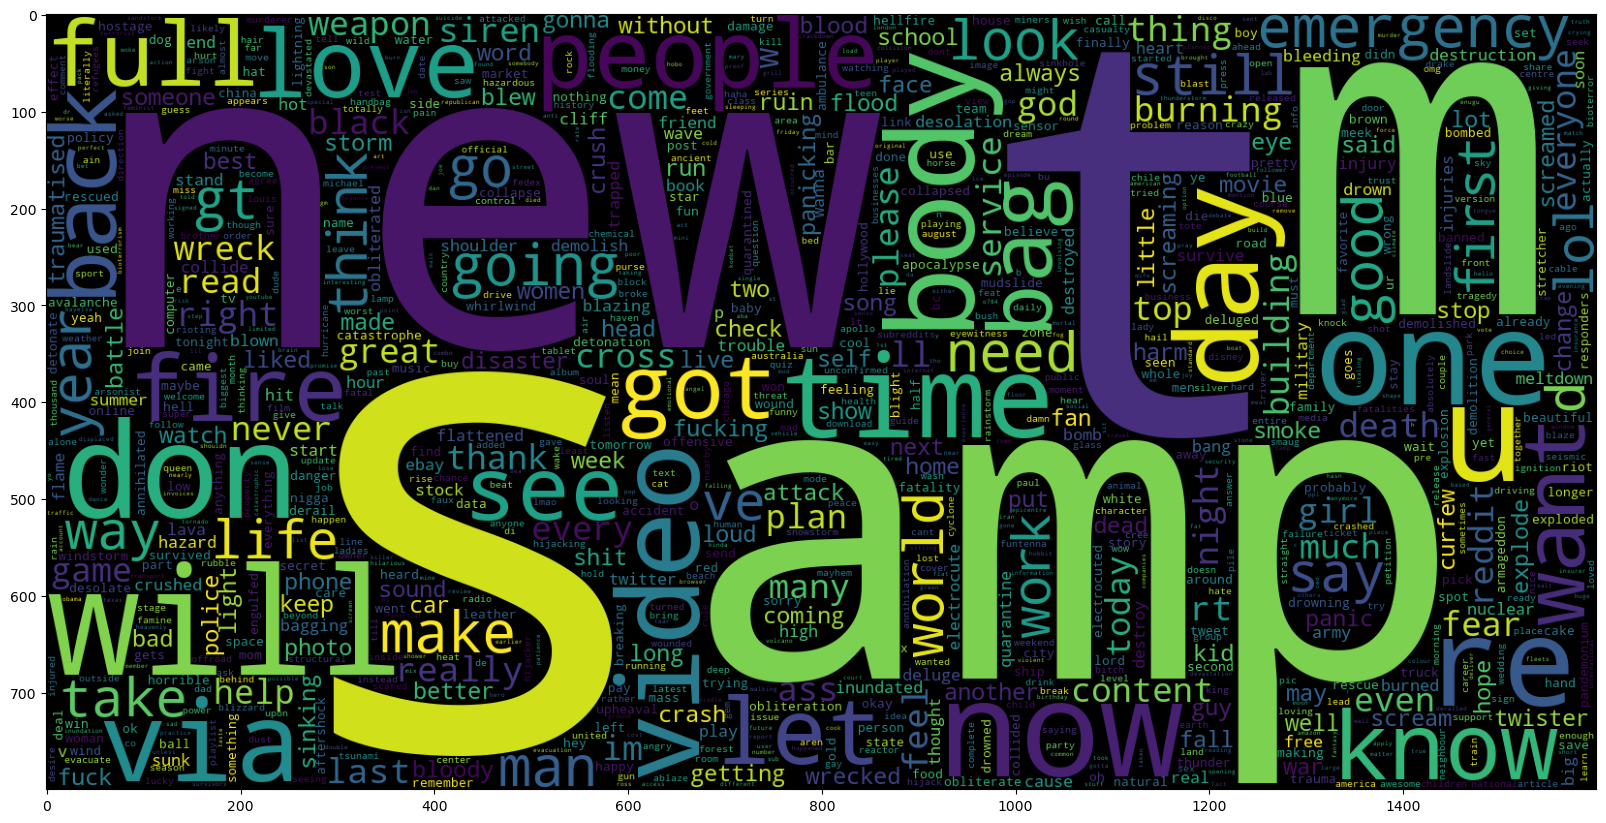

In [46]:
gen_wordcloud(neg)

# Data prep

Here I prepare the data for deep learning. All I'm doing here is loading the [GloVe](https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation) word embeddings, and creating an embedding matrix with them. Once I have that I replace every word in the dataset with its index into the embedding matrix.

In [47]:
embeddings_text = open('/kaggle/input/glove100d/glove.6B.100d.txt', 'r', encoding='utf-8')

In [48]:
words = {}
for example in data:
    for word in example.split():
        if word not in words:
            words[word] = 0
        else:
            words[word] += 1

In [49]:
embs = {}
for line in embeddings_text:
    split = line.split()
    word = split[0]
    if word in words.keys():
        try:
            embedding = np.array([float(value) for value in split[1:]])
            embs[word] = embedding
        except:
            print('error loading embedding')

In [50]:
missing_words = 0
for word in words:
    if word not in embs:
        missing_words += 1
print(missing_words)

1411


In [51]:
embedding_matrix = []
idx_to_word = []
word_to_idx = {}
embedding_matrix.append(np.zeros(100)) # this will be our zero padding for the network
idx_to_word.append('')
word_to_idx[''] = 0
for i, (word, emb) in enumerate(embs.items()):
    embedding_matrix.append(emb)
    idx_to_word.append(word)
    word_to_idx[word] = i + 1
embedding_matrix = np.asarray(embedding_matrix)

In [52]:
index = word_to_idx['depression']
print(index)
print(idx_to_word[index])
print(np.array_equal(embs['depression'], embedding_matrix[index]))
print(embedding_matrix.shape)

3365
depression
True
(12113, 100)


In [53]:
x_train = []
for example in data:
    temp = []
    for word in example.split():
        if word in word_to_idx:
            temp.append(word_to_idx[word])
    x_train.append(temp)

In [54]:
x_train = np.asarray(x_train)

/tmp/ipykernel_28/909520269.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.asarray(x_train)


In [55]:
x_train.shape

(7613,)

In [56]:
max_length = 0
for example in x_train:
    if len(example) > max_length:
        max_length = len(example)
max_length

34

In [57]:
def tokens_to_string(tokens):  # Convert tokens back into their sting value
    words = [idx_to_word[token] for token in tokens]
    text = " ".join(words)
    return text
print(x_train[0])
print(tokens_to_string(x_train[0]))

[1866, 2607, 5, 809, 953, 363, 136]
civilian casualties in afghanistan reach record high


## Pad sequences to be the same length

In [58]:
pad = 34
for i in range(len(x_train)):
    x_train[i] = np.pad(x_train[i], (pad - len(x_train[i]), 0), 'constant')

In [59]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1866, 2607,    5,  809,  953,  363,
        136])

In [60]:
x_train.shape

(7613,)

In [61]:
x_train_data = []
for x in x_train:
    x_train_data.append([k for k in x])

In [62]:
x_train_data = np.array(x_train_data)
x_train_data.shape

(7613, 34)

# Model Architecture

For this project I am using an LSTM-RNN. The model is one directional and one layer deep. The number of time step is equal to the length of the longest tweet which is 157 words long. With a sequence length of 157 the LSTM model should perform a lot better than normal RNN's as it will be able to remember much longer sequences.

In [63]:
class RNN(nn.Module):
    def __init__(self, embeddings, LSTM_dim, n_layers, bidirectional):
        super().__init__()
        
        self.embedding = nn.Embedding(embeddings.shape[0], embeddings.shape[1])
        self.embedding.load_state_dict({'weight': embeddings})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embeddings.shape[1], LSTM_dim, num_layers=n_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(LSTM_dim, 1)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_x):
        # input_x is expected to be of size (example length, batch size) however the axes are
        # flipped so we permute them to be the correct size.
        embedded = self.embedding(input_x.permute(1,0)) 
        # embedded size = (example length, batch size, embedding dimensions)
        output, (hidden, cell) = self.lstm(embedded)
        # hidden size = (number of layers * number of directions, batch size, number of hidden units)
        output = self.dropout(hidden[-1])
        # output size = (batch size, number of hidden units)
        output = self.fc(output)
        # output size = (batch size, 1)
        output = self.sigmoid(output)
        
        return output

In [76]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNN(torch.tensor(embedding_matrix), 128, 1, False).to(device)

In [77]:
batch_size = 128
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [78]:
class CustomDataset(Dataset):
    def __init__(self, examples, labels):
        self.examples = examples
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        example = torch.IntTensor(self.examples[idx])
        label = self.labels[idx]
        
        return example, label

In [79]:
dataset = CustomDataset(x_train_data, labels)

train_length = int(len(dataset) * 0.9)
test_length = len(dataset) - train_length

x_dataset, y_dataset = random_split(dataset, [train_length, test_length])
x_train_dataloader = DataLoader(x_dataset, batch_size=batch_size, shuffle=False)
y_test_dataloader = DataLoader(y_dataset, batch_size=batch_size, shuffle=False)

print(len(x_train_dataloader) * batch_size)
print(len(y_test_dataloader) * batch_size)

6912
768


In [80]:
def train(epochs):
    for epoch in range(epochs):
        for i, (batch, labels) in enumerate(x_train_dataloader):
            batch, labels = batch.to(device), labels.to(device)
            labels = labels.reshape((len(labels), 1))
            labels = labels.float()
            
            model.zero_grad()
            
            output = model(batch)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            if i == 0:
                print(f'Epoch: {epoch+1}/{epochs} Loss: {loss}')

In [81]:
train(40)

Epoch: 1/40 Loss: 0.6939378976821899
Epoch: 2/40 Loss: 0.6829987168312073
Epoch: 3/40 Loss: 0.6181987524032593
Epoch: 4/40 Loss: 0.5155470967292786
Epoch: 5/40 Loss: 0.46826574206352234
Epoch: 6/40 Loss: 0.44018587470054626
Epoch: 7/40 Loss: 0.41829490661621094
Epoch: 8/40 Loss: 0.4002503454685211
Epoch: 9/40 Loss: 0.39185094833374023
Epoch: 10/40 Loss: 0.37900087237358093
Epoch: 11/40 Loss: 0.38681817054748535
Epoch: 12/40 Loss: 0.3773338794708252
Epoch: 13/40 Loss: 0.3776894211769104
Epoch: 14/40 Loss: 0.37628495693206787
Epoch: 15/40 Loss: 0.3782705068588257
Epoch: 16/40 Loss: 0.37308913469314575
Epoch: 17/40 Loss: 0.3707340359687805
Epoch: 18/40 Loss: 0.37116825580596924
Epoch: 19/40 Loss: 0.36099952459335327
Epoch: 20/40 Loss: 0.36204349994659424
Epoch: 21/40 Loss: 0.36075878143310547
Epoch: 22/40 Loss: 0.36282050609588623
Epoch: 23/40 Loss: 0.3658285140991211
Epoch: 24/40 Loss: 0.35236597061157227
Epoch: 25/40 Loss: 0.3505457043647766
Epoch: 26/40 Loss: 0.34545159339904785
Epoch:

# Results and Conclusion

This model performs decently with an accuracy of 80% on the validation set. The main challenge I faced with this project was the fact the dataset was so small, with small of a dataset it was very easy to overfit and very difficult to get a high accuracy. Maybe transfer learning would have worked better here since there is so little data. The being said I learned a lot about RNN's and natural language processing doing this project and overall I'm happy with the results.

In [82]:
def print_accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for messages, labels in dataloader:
            messages = torch.tensor(messages).to(device)
            outputs = model(messages)
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            outputs = outputs >= 0.5
            labels = labels == 1.0
            total += len(labels)
            for i in range(len(labels)):
                if labels[i] == outputs[i][0]:
                    correct += 1
    print(correct / total)

In [83]:
print_accuracy(x_train_dataloader)
print_accuracy(y_test_dataloader)

0.8413370310903517
0.8070866141732284


/tmp/ipykernel_28/3151982353.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


In [84]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [85]:
def cm(dataloader):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    with torch.no_grad():
        for messages, labels in dataloader:
            messages = torch.tensor(messages).to(device)
            outputs = model(messages)
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            outputs = outputs >= 0.5
            labels = labels == 1.0
            for i in range(len(labels)):
                if outputs[i] == True:
                    if labels[i] == True:
                        true_pos += 1
                    else:
                        false_pos += 1
                else:
                    if labels[i] == False:
                        true_neg += 1
                    else:
                        false_neg += 1
    return np.asarray([[true_neg, false_neg], [false_pos, true_pos]])

In [87]:
cm_ = cm(y_test_dataloader)

/tmp/ipykernel_28/1465458185.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


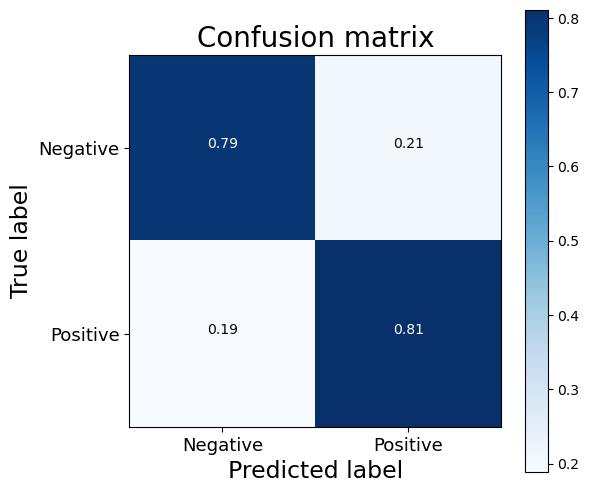

In [88]:
cnf_matrix = np.asarray(cm_)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'], title="Confusion matrix")
plt.show()

In [89]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [90]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [91]:
test_data = [x for x in test_df['text']]

In [92]:
x_test = []
for example in test_data:
    temp = []
    for word in example.split():
        if word in word_to_idx:
            temp.append(word_to_idx[word])
    x_test.append(temp)

In [93]:
x_test[0]

[1435, 6, 4056, 540, 1783]

In [94]:
pad = 34
for i in range(len(x_test)):
    x_test[i] = np.pad(x_test[i], (pad - len(x_test[i]), 0), 'constant')

In [95]:
x_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 1435,    6, 4056,  540,
       1783])

In [96]:
x_test_dataloader = DataLoader(x_test, batch_size=batch_size, shuffle=False)

In [97]:
test_output = []
with torch.no_grad():
    for messages in x_test_dataloader:
        messages = torch.tensor(messages).to(device)
        messages = messages.type(torch.IntTensor).to(device)
        outputs = model(messages)
        outputs = outputs.detach().cpu().numpy()
        outputs = outputs >= 0.5
        for out in outputs:
            if out[0]:
                test_output.append(1)
            else:
                test_output.append(0)

/tmp/ipykernel_28/4233075497.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


In [98]:
submission_df = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [99]:
for i in range(len(test_output)):
    submission_df['target'].iloc[i] = test_output[i]
    

In [100]:
submission_df.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [101]:
submission_df.to_csv("submission.csv", index=False)